# Price and Company data for the S&P 500

# Overview

This DataSet came from kaggle.  To see a comprehensive overview 
visit: https://www.kaggle.com/dgawlik/nyse

It contains several files that have features suitable for both:

    - Technical Analysis (utilizing pricing data for a stock,,,to gauge the effects of supply-and-demand)
    - Fundamental Analysis (utilizing features that describe the health of the core business to gauge value)

For this analysis I will focus on the technical data from (2010-2016) contained within prices-split-adjusted.csv.  

# What's in our dataset ?

Firstly, let us load our prices-split-adjusted.csv into a Pandas DataFrame.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sps
import datetime
import matplotlib
%matplotlib inline

# global stock dataframe
stock_df = ''

In [49]:
stocks_df = pd.read_csv('nyse/prices-split-adjusted.csv').sort_values(by=['date'])
stocks_df.head(1)

,date,symbol,open,close,low,high,volume
646,2010-01-04,SYMC,18.040001,18.4,18.01,18.530001,8322300.0


The relevant features here are the pricing columns (open, close, low, high) for the current day.  
The volume feature is the number of daily transactions for the stock.

Now that the data is loaded let's calculate the mean and standard deviation for a specific stock.
We will use Apple (AAPL) as our population sample

In [50]:
apple_df = stocks_df[stocks_df['symbol'] == 'AAPL']
apple_high_df1_np = apple_df['high'].values
#df1['high'].sort_values(by=['date']).values
apple_df.sort_values(by=['date'])
apple_high_df1_np

array([ 30.64285657,  30.79857057,  30.74714286, ..., 118.019997  ,
       117.110001  , 117.199997  ])

Once we've filtered out Apple's data we can use numpy to evaluate the mean and standard deviation.

In [51]:
apple_mean = np.mean(apple_high_df1_np)
apple_sd = np.std(apple_high_df1_np)
apple_max = np.max(apple_high_df1_np)
apple_min = np.min(apple_high_df1_np)
print('mean: ', apple_mean, '\nstddev: ', apple_sd, "\nminimum: ", apple_min, "\nmaximum: ", apple_max)

mean:  80.1404466937349 
stddev:  28.552921387426345 
minimum:  28.0 
maximum:  134.53999299999998


Regarding Apple's Stock price highs for this period, we can say they have an average of \$80 and a standard deviation of \$29, 

along with a 
minimim high of \$28 and a maximum of \$134.  But...

# Are Stock Prices a Normal Distribution ?

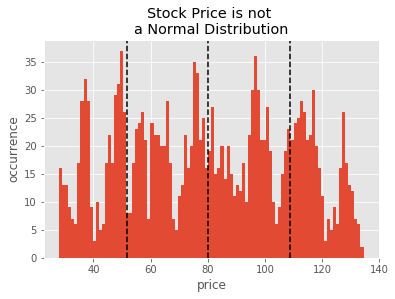

In [52]:
plt.hist(apple_high_df1_np, 100)
plt.axvline(x=apple_mean,linestyle='dashed',color='black')
plt.axvline(x=apple_mean+apple_sd,linestyle='dashed', color='black')
plt.axvline(x=apple_mean-apple_sd,linestyle='dashed', color='black')
plt.xlabel('price')
plt.ylabel('occurrence')
plt.title('Stock Price is not \na Normal Distribution')
plt.show()

As we can see from the chart, the mean and stadard deviation markings coincide with our earlier calculations.  Since a normal-distrubtion contains 95% of the data within 2 - stddevs we can conclude that Stock Prices are not normally distributed

# Are Stock Prices highly-correlated with Volume ?

In [53]:
from scipy.stats import pearsonr
np.corrcoef(apple_df['high'], apple_df['volume'])
pearsonr(apple_df['high'], apple_df['volume'])

(-0.5786810533613387, 4.709065212392541e-158)

### According to the Pearson test, a correlation value of -0.57 means a moderate, negative correlation  with a statistical significance because of the small pvalue (4.7e-158) (It was Not by chance)

#### Visually, I would expect a graph where there the line of best fit is negative and moderately sloped.


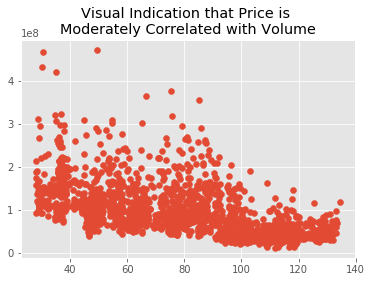

In [54]:
matplotlib.style.use('ggplot')
plt.scatter(apple_df['high'], apple_df['volume'])
plt.title('Visual Indication that Price is \nModerately Correlated with Volume')
plt.show()

Price and Volume are not highly-correlated.  Using the np.corrceof method we can see that Stock Prices and Volume are moderately (negative) correlated with each other. 

The scatterplot of the high-price and volume features shows that this conclusion visually.  Notice that the slope of line of best fit is negative and that the clustering of the values is loosley coupled.

# How do the other features in the pricing dataset correlate with volume ?

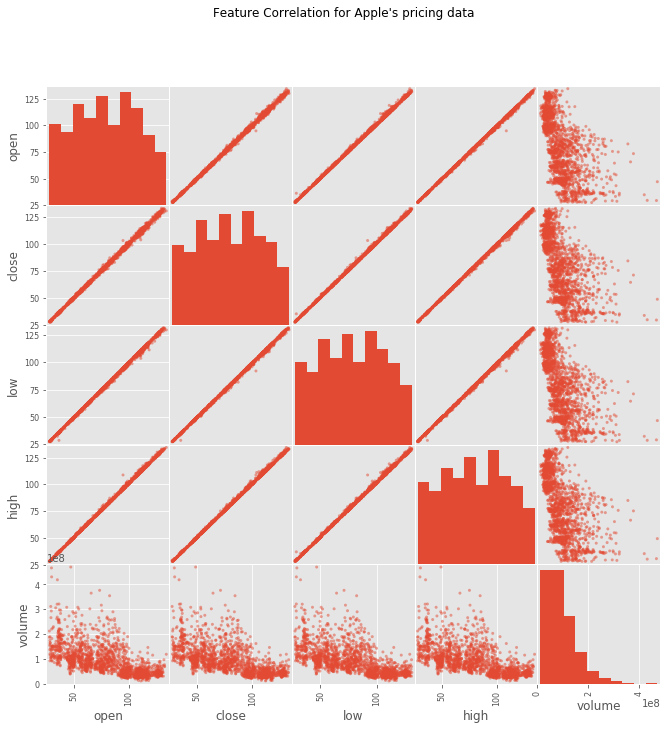

In [55]:
pd.plotting.scatter_matrix(apple_df, figsize=(11,11))
plt.suptitle("Feature Correlation for Apple's pricing data")
plt.show()

# How does AAPL compare with other stocks ?

To compare AAPL with other stocks, I have created functions that can be applied to other stock symbols.

In [56]:
###################################################################
##
## This function will take 2 features print the statistical summary
##
###################################################################
def DescribeStock( symbol, column ):
    global stock_df
    print('symbol: ',symbol, ' column: ', column)
    stock_df = stocks_df[stocks_df['symbol'] == symbol]
    stock_np = stock_df[column].values
    print(stock_df[column].describe())
    return

In [57]:
###################################################################
##
## Given the stock-symbol, feature, & # of bins, this function will 
## Display the histogram
##
###################################################################
def Histogram( stock, column, bins ):
    stock_df = stocks_df[stocks_df['symbol'] == stock]
    #print(stock_df)
    stk_mean = np.mean(stock_df[column].values)
    stk_sd = np.std(stock_df[column].values)
    plt.hist(stock_df[column].values, bins)
    plt.axvline(x=stk_mean,linestyle='dashed',color='black')
    plt.axvline(x=stk_mean+stk_sd,linestyle='dashed', color='black')
    plt.axvline(x=stk_mean-stk_sd,linestyle='dashed', color='black')
    plt.xlabel('Price')
    plt.ylabel('Occurence')
    plt.title('Price Distribution for: ' + stock)
    plt.show()
    return

In [58]:
###################################################################
##
## Given the stock-symbol, feature, & # of bins, this function will 
## calculate the t-value for a normal-distribution
##
###################################################################
def Calculate_T_Value(symbol, feature_a, feature_b, year):
    #Year filter
    stocks_df['date'] = pd.to_datetime(stocks_df['date'])
    datetime1 = datetime.date(year,1,1) 
    ByYear = stocks_df['date'] >= datetime1
    
    #Symbol Filter
    BySymbol = stocks_df['symbol'] == symbol

    stock_df = stocks_df[BySymbol & ByYear]
    stock_feature_a_np = stock_df[feature_a].values
    stock_feature_b_np = stock_df[feature_b].values
    
    # t-value use scipy
    from scipy.stats import ttest_ind
    print(ttest_ind(stock_feature_b_np, stock_feature_a_np, equal_var=False))
    return

In [72]:
###################################################################
##
## Given the stock-symbol, feature, & # of bins, this function will 
## calculate the t-value for a normal-distribution
##
###################################################################
def DescribeStockByYear( symbol, column, year ):
    global stock_df
    stocks_df['date'] = pd.to_datetime(stocks_df['date'])
    datetime1 = datetime.date(year,1,1) 
    ByYear = stocks_df['date'] >= datetime1
    BySymbol = stocks_df['symbol'] == symbol
    print('symbol: ',symbol, ' summary-year: ', year)
    stock_df = stocks_df[BySymbol & ByYear]
    stock_np = stock_df[column].values
    #print(stock_df[column].describe().mean)
    summary = stock_df[column].describe()
    summary_list = list(summary)
    #print('\tmean: ', summary_list[1], '\n\tstd: ', summary_list[2])
    #print(summary)
    print(stock_df[column].describe().mean)
    #DescribeStockByYear('AMZN', 'high', 2016)
    return summary_list

symbol:  AMZN  column:  high
count    1762.000000
mean      341.464438
std       190.525796
min       111.290001
25%       195.532501
50%       285.074997
75%       402.082496
max       847.210022
Name: high, dtype: float64


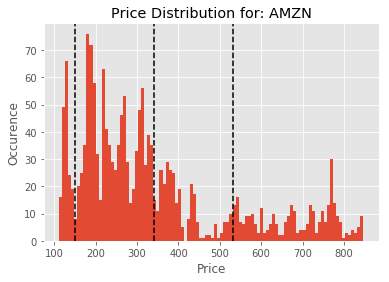

In [74]:
symbol = 'AMZN'
column = 'high'
DescribeStock(symbol, column)
Histogram(symbol, column, 100)

# For exploring the data, list out all the Unique Stocks listed in our DataSet

In [61]:
stocks_df.symbol.unique()

array(['SYMC', 'IFF', 'ILMN', 'INTC', 'INTU', 'IP', 'IPG', 'IR', 'IRM',
       'IDXX', 'ISRG', 'IVZ', 'JBHT', 'JCI', 'JEC', 'JNJ', 'JNPR', 'JPM',
       'JWN', 'ITW', 'K', 'ICE', 'HUM', 'HBAN', 'HBI', 'HCN', 'HCP', 'HD',
       'HES', 'HIG', 'HOG', 'IBM', 'HOLX', 'HP', 'HPQ', 'HRB', 'HRL',
       'HRS', 'HSIC', 'HST', 'HSY', 'HON', 'KEY', 'KIM', 'KLAC', 'M',
       'MA', 'MAC', 'MAR', 'MAS', 'MAT', 'MCD', 'MCHP', 'LVLT', 'MCK',
       'MDLZ', 'MDT', 'MET', 'MHK', 'MJN', 'MKC', 'MLM', 'MMC', 'MCO',
       'LUV', 'LUK', 'LRCX', 'KMB', 'KMX', 'KO', 'KR', 'KSS', 'KSU', 'L',
       'LB', 'LEG', 'LEN', 'LH', 'LKQ', 'LLL', 'LLTC', 'LLY', 'LMT',
       'LNC', 'LNT', 'LOW', 'HAS', 'HAR', 'HAL', 'GWW', 'DTE', 'DUK',
       'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'DRI', 'EFX', 'EL', 'EMN',
       'EMR', 'ENDP', 'EOG', 'EQIX', 'EQR', 'EQT', 'EIX', 'DPS', 'DOW',
       'DOV', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS',
       'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DLR

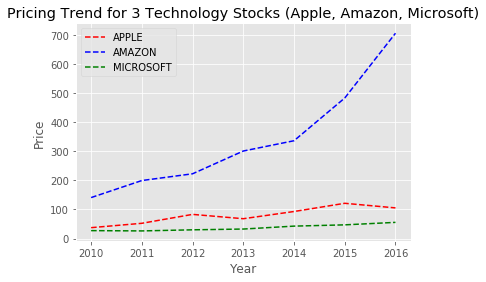

In [62]:
pd.options.mode.chained_assignment = None
stocks_df['date'] = pd.to_datetime(stocks_df['date'])
stocks_df['year'] = stocks_df['date'].dt.year
stocks_df['month'] = stocks_df['date'].dt.month
stocks_df['day'] = stocks_df['date'].dt.day

grouped_by_df = pd.pivot_table(stocks_df, index = ['symbol','year'], values= "high")
fig, ax = plt.subplots()
plt.plot(grouped_by_df.loc['AAPL'],'r--', label='APPLE')
plt.plot(grouped_by_df.loc['AMZN'], 'b--', label='AMAZON')
plt.plot(grouped_by_df.loc['MSFT'], 'g--', label='MICROSOFT')
plt.title('Pricing Trend for 3 Technology Stocks (Apple, Amazon, Microsoft)')
plt.xlabel('Year')
plt.ylabel('Price')
leg = ax.legend();

# Compute the Mann-Whitney rank test on two Stocks (Apple, Amazon)

In [66]:
from scipy.stats import mannwhitneyu
sample_a = grouped_by_df.loc['AAPL']
sample_b = grouped_by_df.loc['AMZN']
mannwhitneyu(sample_a, sample_b)

MannwhitneyuResult(statistic=0.0, pvalue=0.0010825146665191896)

### NULL Hypothesis: The stock performance between APPLE and AMAZON between 2010-2016 are similar

According to the Mann Whitney test, 
the pvalue for these 2 stocks for this time period the samples are statistically different.  99.9% confidence to reject my NULL Hypothesis.

# Using a candlestick chart, What is the trend for Open, High, Low, & Close prices for a given stock ?

A candlestick chart represents the open, high, low, & close price for a given day.  Using the finance library of matplotlib, I am able to etract the given stock and chart the data for all the datapoints in the given dataset.

In [64]:
# Add headers for all - functions
def bytespdate2num(fmt, encoding='utf-8'):
    import matplotlib.dates as mdates
    strconverter = mdates.strpdate2num(fmt)
    def bytesconverter(b):
        s = b.decode(encoding)
        return strconverter(s)
    return bytesconverter

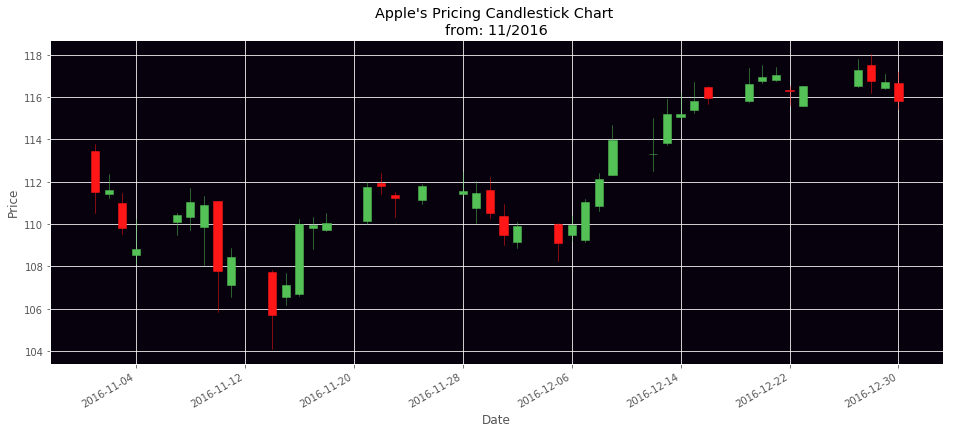

In [65]:
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.widgets import Slider


# get all data for Apple
by_symbol = stocks_df['symbol'] == 'AAPL'
stock_df = stocks_df[by_symbol]

# filter Apple data by month & year
month = 11
year = 2016
by_month = stock_df['month'] >= month
by_year = stock_df['year'] == year
stock_df = stock_df[by_month & by_year]

# extract pricing data for the candlestick chart
df1 = stock_df[['date','open','high','low','close','volume']]
fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot2grid((6, 4), (1, 0), rowspan=6, colspan=4, facecolor='#07000d')
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
fig.autofmt_xdate()
ax1.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Apple's Pricing Candlestick Chart \nfrom: " + str(month) + '/' + str(year))
df1.is_copy = False
df1['date'] = mdates.date2num(pd.Index(df1['date']).to_pydatetime())
_ = candlestick_ohlc(ax1, df1.values, width=.6, colorup='#53c156', colordown='#ff1717')

# We can see from the chart, Apple's stock has been on an upward trend for the entire month of December 2016





# What other analysis can we do with this data ?

### More interesting analysis can be done if we add 'calculated' features to our dataset.  Metrics such has moving averages and determining the average daily range can be used to make trading suggestions.

### Comparing yearly technical values vs the 10K filing data would be appropriate.  In this regard, the annual fundamentals of a stock will give the technical analysis additional context.


#### Using calculated features may also be used for predictive or probability trading.  Patterns that will be useful will be determing local highs and lows which can signal a short or long position to maxize trading gains.  These kinds of trades are known as swing trades as they signal a breakout movement in pricing which signal big differentials in supply and demand for a stock.

#### Other useful datapoints to consider are when the stock is less volatile.  In the candle stick chart above there are several periods where Apple's stock is stable within a small price range.  These 'smaller' ranges would be excellent opportunities for arbitrage trading where the investor is finding local maxima and minima to gain reliable points.

##### Also, my initial analysis of this data focused on a single stock (APPLE).  A future question could be a clustering problem that finds the highest grouping of most profitable stocks in a given time period.

# Other Questions to consider:

    ## What stocks are the most stable (least variation) in terms of price data ?
    ## How are stock prices (on a year-to-year basis) correlated to the company's earnings ?
    ## How does a stock's price correlate to the company's known debt obligation ?
    ## What time of the year is a stock's most significant gains made ?
    ## Is there a pattern for when a particular stock bottoms out ?

